# Preliminary Tests and Findings

This notebook is a compilation of my favorite parts of many notebooks I created for this competition. It might not have been the best performing, but I picked this one because it had my favorite parts of all my attempts. Actually, it is one of at least 40 notebooks I created for this project. One of my biggest challenges was that I wasn't able to run the code efficiently in the cloud, so I had to use my own PC to fit and predict the models. Therefore, I settled for this 1% sample version as a showcase. The purpose of this notebook is to demonstrate my workflow and interpretation of each part.

## Early Explorations

I first started with a little exploratory data analysis (EDA) and basic data processing. The data comes pretty clean, but the dataset is MASSIVE. The largest I had worked with previously had been around 70k rows, but this one had 11 million. Not many columns though. Most columns were fairly easy to handle except for `Region_Code` and `Policy_Sales_Channel`. I treated those by binning them into a rare category due to the heavy imbalance towards some values. Otherwise, everything was treated pretty basically.

I made some basic EDA graphs to explore the data, using some base models to understand feature importances. Later, I discovered the magic of KLIB from another notebook: [Optuna XGBoost KLIB Notebook](https://www.kaggle.com/code/suvroo/ps4e7-optuna-xgboost-klib), which taught me a thing or two about cleaning the data easily with KLIB, and how to keep track of hyperparameter studies with Optuna and some of its also amazing graphs.

## Feature Engineering

At first I applied the basic preprocessing steps neccessary to run the dataset efficiently in the models I was using. Also incorporating some downcasting to the workflow so that the model would work more efficiently. I tried applying some additional transformations to the data like removing outliers, creating rare categories for feature values with low counts and creating KMEANS cluster feature. I also tested borrowed feature interactions from other notebooks and created my own. After possibly hundreds of tests I settled on a combination of my own outlier removal using IQR and a set of feature interactions from [this Kaggle notebook](https://www.kaggle.com/code/rohanrao/automl-grand-prix-1st-place-solution).

## Hyperparameter Studies

After doing hyperparameter studies on LightGBM, XGBoost, CatBoost, and a PyTorch neural network, I realized, while cleaning up my files, that one of my base models had the best metrics so far. That is the one I built this model on. I later implemented Optuna with careful logging of the studies and ran hundreds of different iterations, mixing hyperparameters and different sample sizes to understand how the library worked.


#### Libraries Import

In this section, we import all necessary libraries required for data manipulation, visualization, model building, and evaluation.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import klib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import optuna
from datetime import datetime
import lightgbm as lgb
import os


#### Data Loading

Here, we load the training dataset. This dataset will be used for all subsequent data processing and model training steps. This dataset was created artificially for the Kaggle Playground Series S4E7, based on [this set](https://www.kaggle.com/datasets/annantkumarsingh/health-insurance-cross-sell-prediction-data).


In [2]:
train_df = pd.read_csv(r"C:\Users\paulo\OneDrive\Documents\kaggle_competition_2_datasets\train.csv", index_col='id')

#### Stratified Sampling

Since the target variable is heavily imbalanced, we perform stratified sampling to ensure that the sample maintains the same distribution as the full dataset. Due to the large size of the dataset (11 million rows), we use only 1% for this notebook. In this case I used %40, because I determined in aother notebook that was the ideal size of a sample in order to approximate the performance of using the full dataset.


In [3]:
# Separate features and target variable
X = train_df.drop('Response', axis=1)
y = train_df['Response']

# # Determine sample size (10% of the dataset)
# sample_size = 0.01

# # Stratified sampling
# X_sample, _, y_sample, _ = train_test_split(X, y, train_size=sample_size, stratify=y)

# # Combine sampled features and target variable
# train_df = pd.concat([X_sample, y_sample], axis=1)

#### Display Sampled Data

After performing stratified sampling, we display the first few rows of the sampled dataset to understand its structure and verify the sampling process.


In [4]:
train_df.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11504798 entries, 0 to 11504797
Data columns (total 11 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Gender                object 
 1   Age                   int64  
 2   Driving_License       int64  
 3   Region_Code           float64
 4   Previously_Insured    int64  
 5   Vehicle_Age           object 
 6   Vehicle_Damage        object 
 7   Annual_Premium        float64
 8   Policy_Sales_Channel  float64
 9   Vintage               int64  
 10  Response              int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 1.0+ GB


#### Data Summary

We use the `describe` method to generate summary statistics for the numerical columns in the dataset. This provides insights into the central tendency, dispersion, and shape of the dataset’s distribution.


In [6]:
train_df.describe()

,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07
mean,3.838356e+01,9.980220e-01,2.641869e+01,4.629966e-01,3.046137e+04,1.124254e+02,1.638977e+02,1.229973e-01
std,1.499346e+01,4.443120e-02,1.299159e+01,4.986289e-01,1.645475e+04,5.403571e+01,7.997953e+01,3.284341e-01
min,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,2.630000e+03,1.000000e+00,1.000000e+01,0.000000e+00
25%,2.400000e+01,1.000000e+00,1.500000e+01,0.000000e+00,2.527700e+04,2.900000e+01,9.900000e+01,0.000000e+00
50%,3.600000e+01,1.000000e+00,2.800000e+01,0.000000e+00,3.182400e+04,1.510000e+02,1.660000e+02,0.000000e+00
75%,4.900000e+01,1.000000e+00,3.500000e+01,1.000000e+00,3.945100e+04,1.520000e+02,2.320000e+02,0.000000e+00
max,8.500000e+01,1.000000e+00,5.200000e+01,1.000000e+00,5.401650e+05,1.630000e+02,2.990000e+02,1.000000e+00


#### Missing Values Check

It is essential to check for missing values in the dataset as they can affect the model performance. Here, we count the number of missing values in each column.


In [7]:
train_df.isnull().sum()

Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

#### Initial Observations and Ideas

- **Gender, Driving_License, Regional_Code, Previously_Insured, Vehicle_Age, Vehicle_Damage, Policy_Sales_Channel, and Response** are all categories. I will treat most of them as numerical columns for now, except for Gender, Vehicle_Age, Previously_Insured, and Vehicle_Damage, which I will turn into categories to use in KLIB's streamlined categorical plotting. From previous explorations, I know Driving_License only has 1 negative value, so I will drop it.
- I will later remap those four categories into numerical columns after EDA as part of the preprocessing for the model.
- I will MinMax scale Age and Vintage when standardizing because they have a reasonable range for this type of transformation.


# EDA

I turn some categories I want to plot into category dtype to be compatible with klib, they will automatically switch back to numeric during preprocessing. 

In [8]:
# Convert specified columns to categorical
categorical_columns = ['Gender', 'Vehicle_Age', 'Previously_Insured']

for col in categorical_columns:
    train_df[col] = train_df[col].astype('category')

# Convert 'Previously_Insured' column to a categorical type with specific labels
train_df['Previously_Insured'] = pd.Categorical(train_df['Previously_Insured'], categories=[0, 1], ordered=True)
train_df['Previously_Insured'] = train_df['Previously_Insured'].cat.rename_categories(["Uninsured", "Insured"])


#### Visualizing Data with KLIB

Using KLIB, we create categorical plots to visualize the distribution of categorical features in the dataset. This helps in understanding the balance of different categories within the dataset.

GridSpec(6, 4)

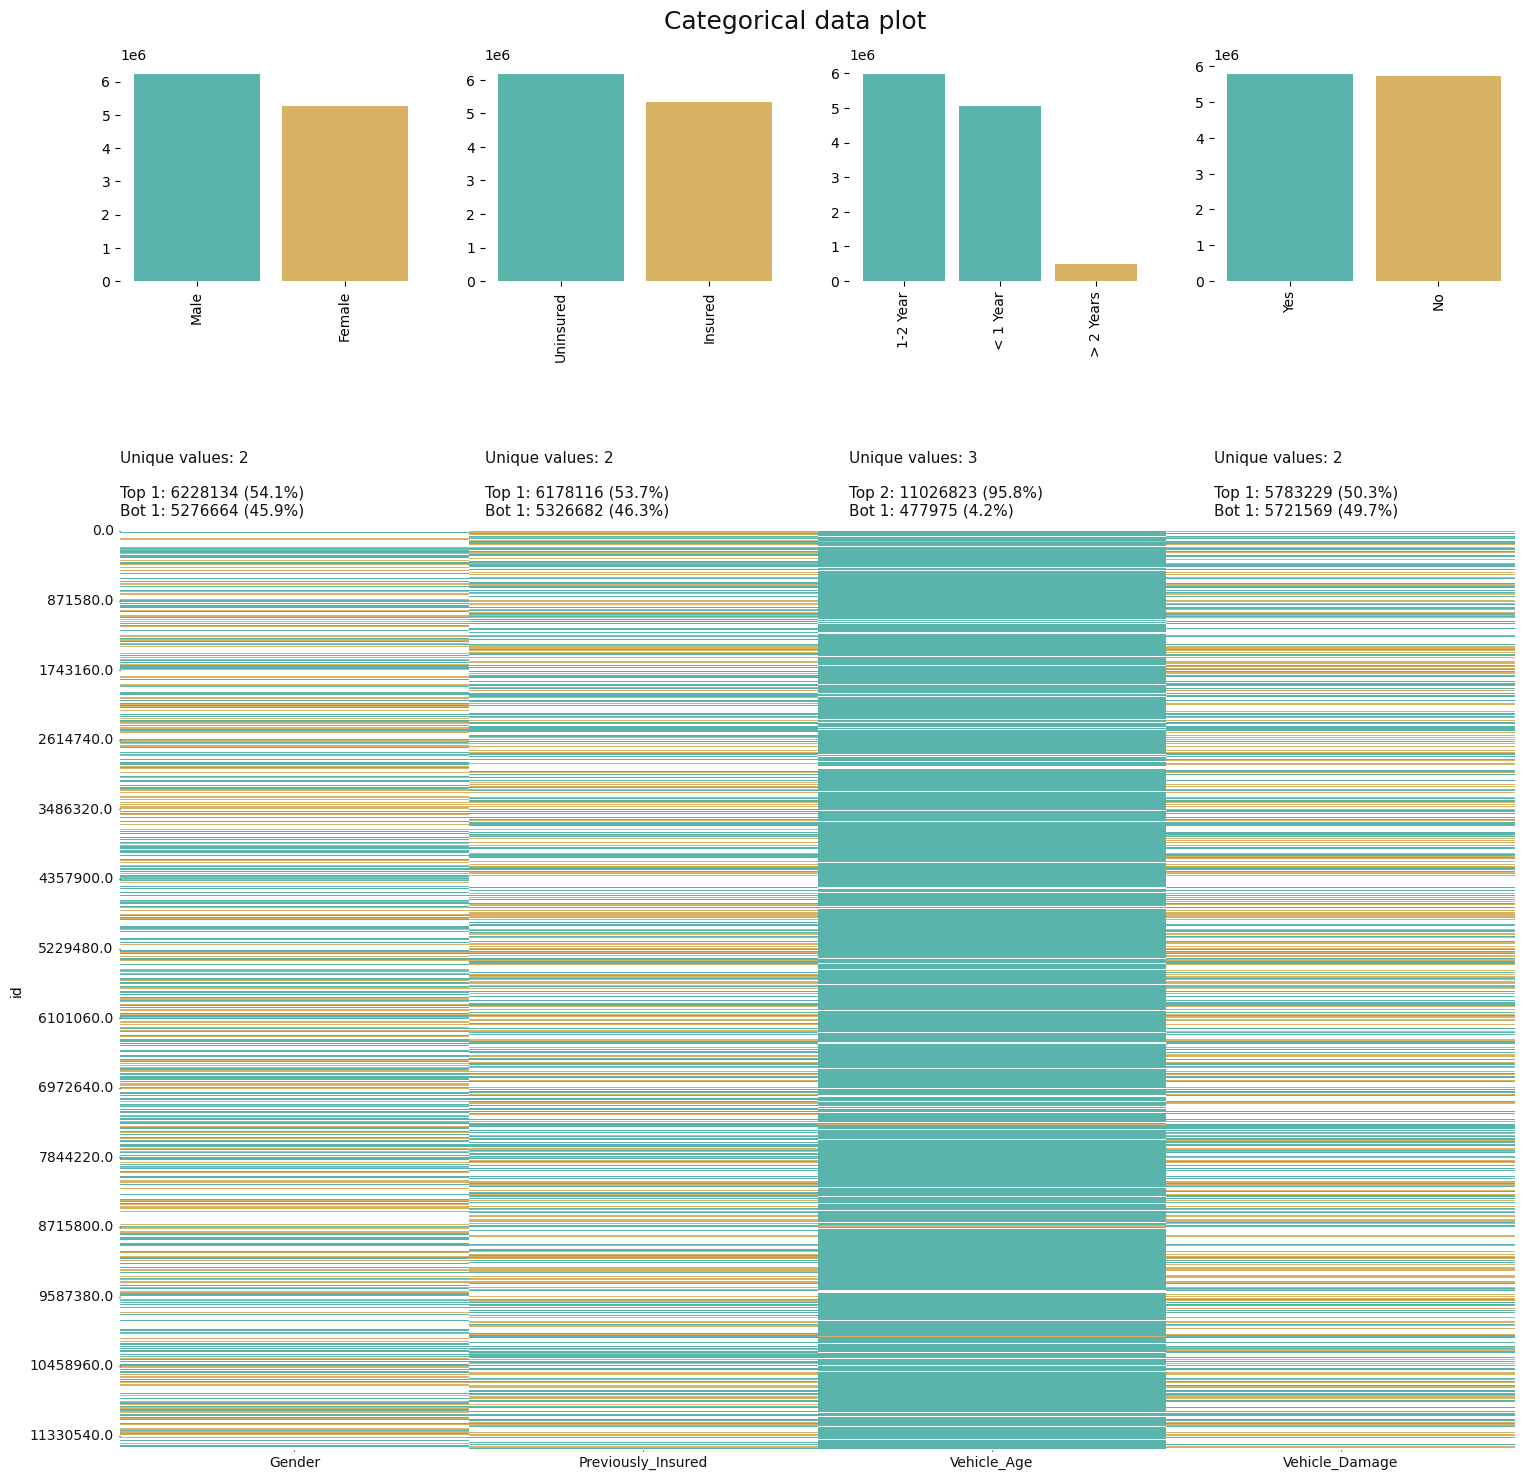

In [9]:
klib.cat_plot(train_df)

#### KLIB Cat Plot Explanation

The KLIB categorical plot is an interesting way of visualizing binary variables within a dataset. However, it doesn't translate too well with categorical variables having more than two possible values.


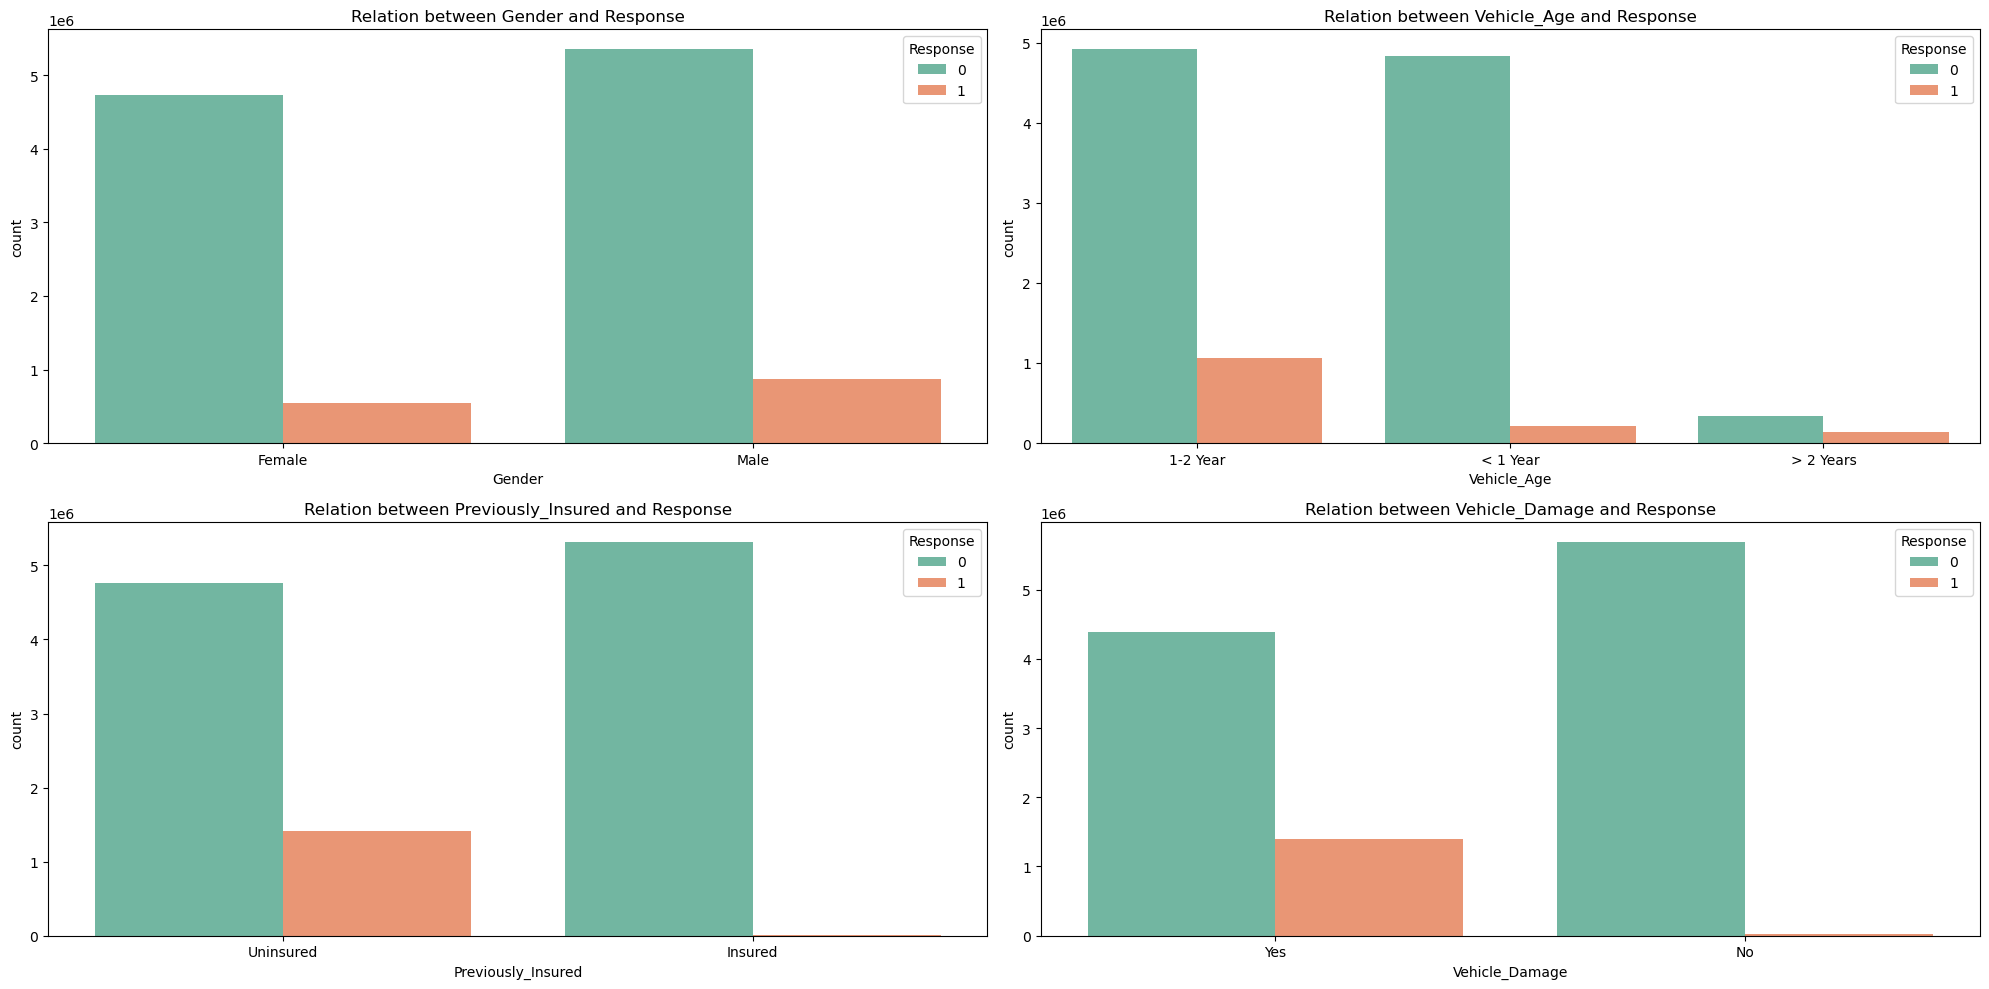

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Function to plot the relationship between categorical variables and the target in a 2x2 single figure
def plot_categorical_vs_target(df, cat_cols, target_col):
    num_plots = len(cat_cols)
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
    palette = ["#66c2a5", "#fc8d62"]  # Custom palette with exactly two colors

    for ax, col in zip(axes.flatten(), cat_cols):
        sns.countplot(data=df, x=col, hue=target_col, ax=ax, palette=palette)
        ax.set_title(f'Relation between {col} and {target_col}')
    
    plt.tight_layout()
    plt.show()

# Plot the relationships
categorical_columns = ['Gender', 'Vehicle_Age', 'Previously_Insured', 'Vehicle_Damage']
plot_categorical_vs_target(train_df, categorical_columns, 'Response')


#### The binary categories were balanced for the most part. Gender's relation to the target doesn't tell us much knowing that there are slightly more Males to begin with. People with newer vehicles are much more likely to insure them. Naturally people that are already insured answered No (who knows if that was a no to switching providers as well). People with no vehicle damage are not very likely to ensure their cars.

#### Distribution Plots with KLIB

We use KLIB to create distribution plots for several features, including Annual_Premium, Age, Region_Code, Policy_Sales_Channel, and Vintage. This helps in understanding the distribution and identifying potential outliers.

Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.
Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.
Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.
Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.
Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.


<Axes: xlabel='Vintage', ylabel='Density'>

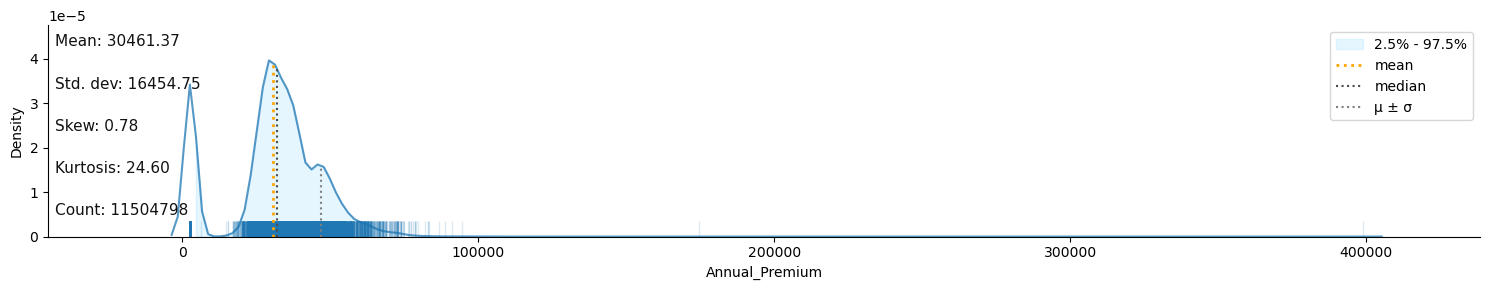

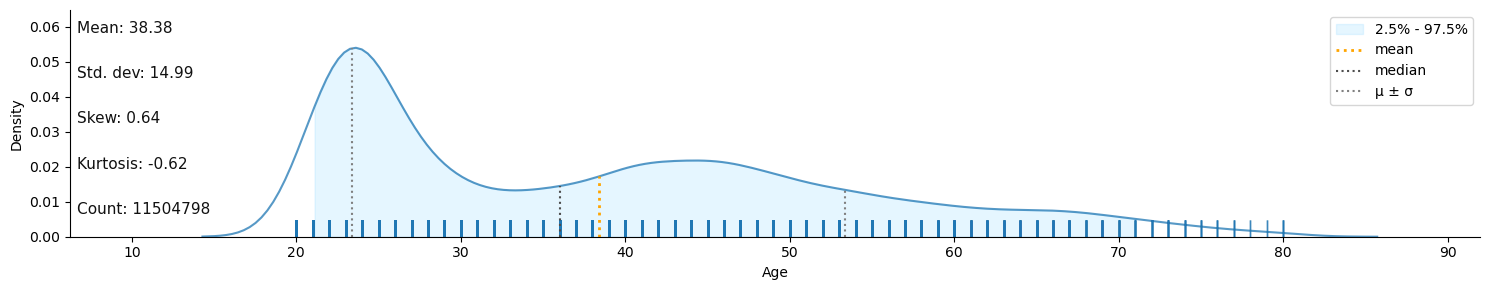

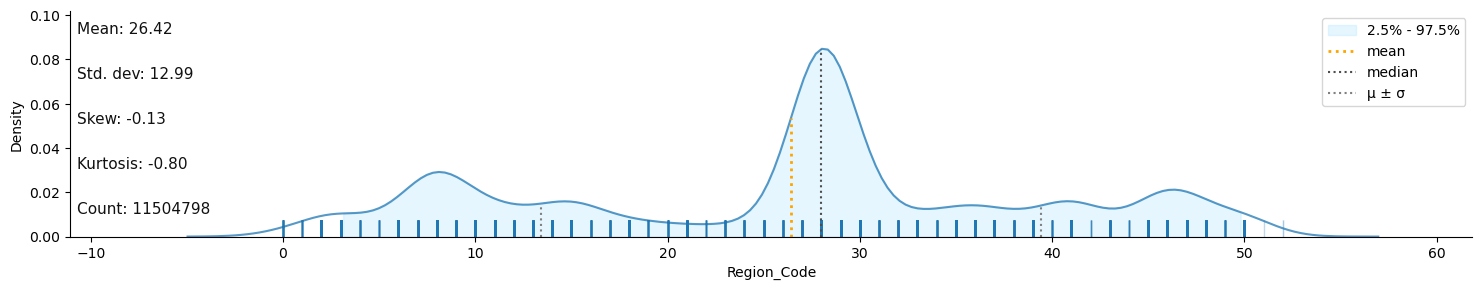

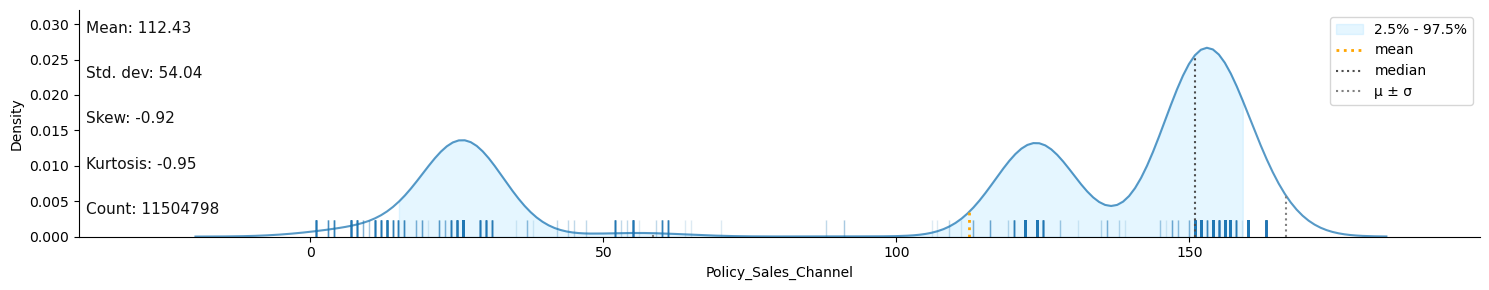

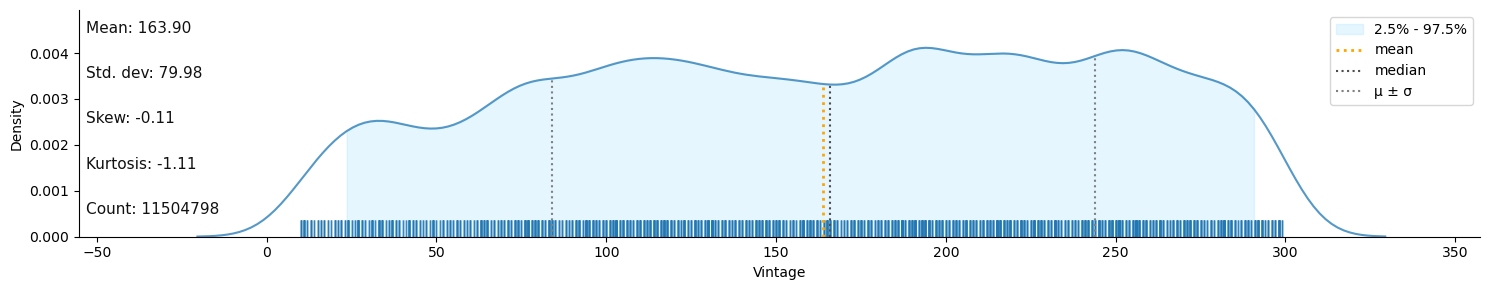

In [11]:
# Plotting categorical features against the target variable
klib.dist_plot(train_df[['Annual_Premium']])
klib.dist_plot(train_df[['Age']])
klib.dist_plot(train_df[['Region_Code']])
klib.dist_plot(train_df[['Policy_Sales_Channel']])
klib.dist_plot(train_df[['Vintage']])

#### Distribution Plot Analysis

- **Annual_Premium** is heavily right-skewed with some heavy outliers in larger numbers. It is also bimodally distributed with a large concentration in the lower values and a second concentration near the mean. I might use a standard outlier removal method or a more aggressive quartile method. It might also benefit from log-transformation for its skewness.
- **Age** is right-skewed, but given the nature of the feature, I will leave it as is and use only a MinMax Scaler during preprocessing.
- **Region_Code** is actually a category but has many different values. It is clear certain regions are much more favored. In a previous notebook, I tried compiling all of the rarer codes into their own category. I might attempt this again but will need to consider that the rare category must be a number in itself for the model.
- **Policy_Sales_Channel** is similar to Region_Code and will be treated the same way.
- **Vintage** is the most normally distributed feature and I will probably scale it with a MinMax Scaler.


#### Encoding Categorical Features

To prepare the categorical features for model training, we convert them into numerical codes. Here, we encode the 'Previously_Insured' feature.

In [12]:
train_df['Previously_Insured'] = train_df['Previously_Insured'].cat.codes

#### Correlation Plot with KLIB

We use KLIB to create a correlation plot to identify relationships between the features and the target variable. This helps in understanding which features might be important for the model.

<Axes: title={'center': 'Feature-correlation (pearson)'}>

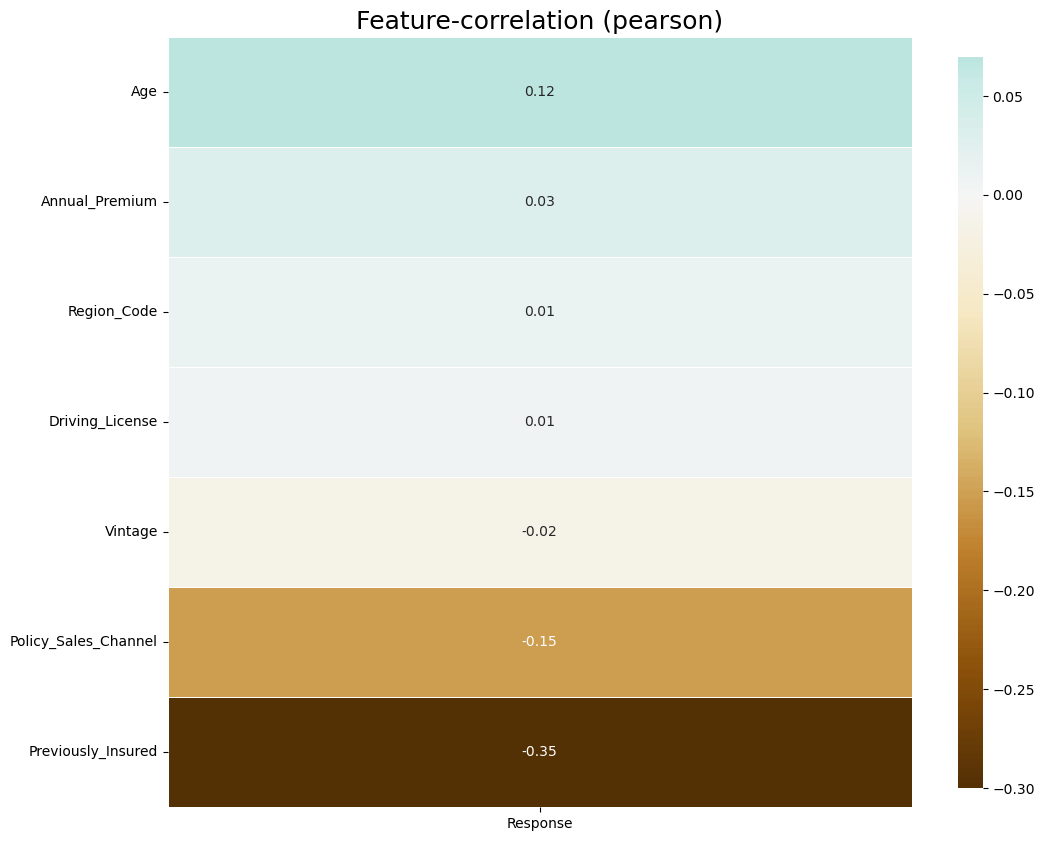

In [13]:
klib.corr_plot(train_df, target='Response')

#### Correlation Plot Analysis

The only feature that seems to have a significant relation towards conversion on the target is whether people are uninsured prior to the call.

# Preprocessing

### Preprocessing Data

In this step, we preprocess the data by transforming binary variables, encoding ordinal features, and scaling continuous features. This prepares the dataset for model training.


In [14]:
# Preprocess data
def preprocess_data(df):
    # Transform binary variables
    df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0})
    df['Vehicle_Damage'] = df['Vehicle_Damage'].map({'Yes': 1, 'No': 0})
    
    # Ordinal Encoding for Vehicle_Age
    vehicle_age_mapping = {'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2}
    df['Vehicle_Age'] = df['Vehicle_Age'].map(vehicle_age_mapping)
    
    # Drop Driving_License due to limited variability
    df.drop(['Driving_License'], axis=1, inplace=True)
    
    # Min-Max Scaling for Age and Vintage
    df['Age'] = (df['Age'] - df['Age'].min()) / (df['Age'].max() - df['Age'].min())
    df['Vintage'] = (df['Vintage'] - df['Vintage'].min()) / (df['Vintage'].max() - df['Vintage'].min())
    
    return df

train_data = preprocess_data(train_df)

# Feature Engineering

#### Converting Data Types

Here, we convert the data types of certain columns to integers for consistency and efficiency.


In [15]:
train_df[['Gender', 'Vehicle_Age', 'Vehicle_Damage']] = train_df[['Gender', 'Vehicle_Age', 'Vehicle_Damage']].astype('int')
train_df[['Region_Code', 'Annual_Premium', 'Policy_Sales_Channel']] = train_df[['Region_Code', 'Annual_Premium', 'Policy_Sales_Channel']].astype('int')

#### Removing Outliers

We remove outliers from the 'Annual_Premium' feature using the Interquartile Range (IQR) method to ensure the model is not affected by extreme values.


In [16]:
# Remove outliers from Annual_Premium in training data only
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

train_df = remove_outliers_iqr(train_df, 'Annual_Premium')

##### Reference: https://www.kaggle.com/code/rohanrao/automl-grand-prix-1st-place-solution
We create new features by capturing the interactions between them and encoding that into categorical combinations. This can provide additional information to the model and improve its performance.


In [17]:
def feature_engineering(df):
    df = df.copy()  
    df['Previously_Insured_Annual_Premium'] = pd.factorize((df['Previously_Insured'].astype(str) + df['Annual_Premium'].astype(str)))[0]
    df['Previously_Insured_Vehicle_Age'] = pd.factorize((df['Previously_Insured'].astype(str) + df['Vehicle_Age'].astype(str)))[0]
    df['Previously_Insured_Vehicle_Damage'] = pd.factorize((df['Previously_Insured'].astype(str) + df['Vehicle_Damage'].astype(str)))[0]
    df['Previously_Insured_Vintage'] = pd.factorize((df['Previously_Insured'].astype(str) + df['Vintage'].astype(str)))[0]

    return df

train_df = feature_engineering(train_df)

# Downcasting



To optimize memory usage, we downcast numerical columns to more appropriate data types without losing information.


In [18]:
def optimize_dtypes(df):
    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            if 'int' in str(col_type):
                min_val, max_val = df[col].min(), df[col].max()
                if min_val >= np.iinfo(np.int8).min and max_val <= np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif min_val >= np.iinfo(np.int16).min and max_val <= np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif min_val >= np.iinfo(np.int32).min and max_val <= np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif min_val >= np.iinfo(np.int64).min and max_val <= np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            elif 'float' in str(col_type):
                min_val, max_val = df[col].min(), df[col].max()
                if min_val >= np.finfo(np.float16).min and max_val <= np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif min_val >= np.finfo(np.float32).min and max_val <= np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                elif min_val >= np.finfo(np.float64).min and max_val <= np.finfo(np.float64).max:
                    df[col] = df[col].astype(np.float64)
    
    return df

train_df = optimize_dtypes(train_df)


# Optuna Hyperparameter Tuning


We use Optuna to perform hyperparameter tuning for our model. This helps in finding the best set of hyperparameters to improve model performance.


#### Separating Features and Target Variable

We separate the features (X) and the target variable (y) from the preprocessed dataset. This is an essential step before model training.


In [19]:
# Separate features and target variable
X = train_df.drop('Response', axis=1)
y = train_df['Response'] 

#### Feature Scaling

We apply standard scaling to the features to ensure they are on a similar scale. This is important for many machine learning algorithms to perform well.


In [20]:
scaler = StandardScaler()
train_df =  scaler.fit_transform(X)

In [21]:
# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Model Training and Evaluation

Next, we will train our model using LightGBM and evaluate its performance using cross-validation.

#### Most of these values are based on previous searches but I'm leaving some leeway due to the fact that we are using such a small sample.

In [22]:
def objective(trial):
    param = {
        'objective': 'binary',
        'metric': 'auc',
        'lambda_l1': trial.suggest_float('reg_alpha', 0.01, 0.1, log=True),  
        'lambda_l2': trial.suggest_float('reg_lambda', 0.1, 0.3, log=True),  
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.75, 0.85), 
        'subsample': trial.suggest_float('subsample', 0.85, 1.0), 
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.1),  
        'max_depth': trial.suggest_int('max_depth', 16, 32), 
        'num_leaves': trial.suggest_int('num_leaves', 700, 1500), 
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 80),  
        'min_child_weight': trial.suggest_float('min_child_weight', 4.0, 10.0),  
        'min_split_gain': trial.suggest_float('min_split_gain', 0.05, 0.1),  
        'max_bin': trial.suggest_int('max_bin', 400, 500),
        'verbose': -1,  
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 9, 12),
        'early_stopping_round': 100,
    }

    num_boost_round = trial.suggest_int('num_boost_round', 10000, 20000)

    # Create LightGBM dataset
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
    
    # Train model
    bst = lgb.train(
        param,
        train_data, 
        num_boost_round=num_boost_round,
        valid_sets=[valid_data],
    )
    
    # Predict and evaluate
    y_val_pred = bst.predict(X_val, num_iteration=bst.best_iteration)
    auc = roc_auc_score(y_val, y_val_pred)
    return auc

# Create a study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=25)

# Get the best trial
best_trial = study.best_trial
print(f'Best trial score: {best_trial.value}')
print(f'Best trial params: {best_trial.params}')


[I 2024-07-22 15:57:33,302] A new study created in memory with name: no-name-8feac4ff-9843-4933-8e7f-4541784b403c
[I 2024-07-22 16:03:02,050] Trial 0 finished with value: 0.8955543696955597 and parameters: {'reg_alpha': 0.012582553254121364, 'reg_lambda': 0.12971050215174884, 'colsample_bytree': 0.7746952097539053, 'subsample': 0.8997547234720662, 'learning_rate': 0.05529721926170736, 'max_depth': 18, 'num_leaves': 951, 'min_child_samples': 75, 'min_child_weight': 7.553629717437314, 'min_split_gain': 0.05871069615623006, 'max_bin': 453, 'scale_pos_weight': 10.876212298778979, 'num_boost_round': 16128}. Best is trial 0 with value: 0.8955543696955597.
[I 2024-07-22 16:06:13,833] Trial 1 finished with value: 0.8943747070946795 and parameters: {'reg_alpha': 0.04855437004519052, 'reg_lambda': 0.10974262110626617, 'colsample_bytree': 0.8138150667348356, 'subsample': 0.9896375978565501, 'learning_rate': 0.08817973421911152, 'max_depth': 32, 'num_leaves': 865, 'min_child_samples': 52, 'min_chi

Best trial score: 0.8960243358239692
Best trial params: {'reg_alpha': 0.03432385172267505, 'reg_lambda': 0.2998279059616829, 'colsample_bytree': 0.790292183596673, 'subsample': 0.9046878168822107, 'learning_rate': 0.05035039561309864, 'max_depth': 29, 'num_leaves': 1474, 'min_child_samples': 75, 'min_child_weight': 7.661448090878849, 'min_split_gain': 0.09978597066868167, 'max_bin': 499, 'scale_pos_weight': 9.870717062897523, 'num_boost_round': 17349}


### Best Hyperparameters

After tuning, we retrieve the best hyperparameters found by Optuna.


### Final Model Training

We train the final model using the best hyperparameters and evaluate its performance on the test set.


In [23]:
%%capture
# LightGBM parameters
params = study.best_trial.params

# Initialize the LightGBM model
model = lgb.LGBMClassifier(**params, verbose=1)

# Train the model
model.fit(X_train, y_train)

In [24]:
# Make predictions
y_train_pred_proba = model.predict_proba(X_train)[:, 1]
y_val_pred_proba = model.predict_proba(X_val)[:, 1]

# Calculate ROC AUC scores
roc_auc_train = roc_auc_score(y_train, y_train_pred_proba)
roc_auc_val = roc_auc_score(y_val, y_val_pred_proba)

# Print ROC AUC scores
print(f'Training ROC AUC Score: {roc_auc_train}')
print(f'Validation ROC AUC Score: {roc_auc_val}')

In [ ]:
optuna.visualization.plot_optimization_history(study)


In [ ]:
optuna.visualization.plot_intermediate_values(study)


[W 2024-07-21 17:10:22,088] You need to set up the pruning feature to utilize `plot_intermediate_values()`


In [ ]:
optuna.visualization.plot_parallel_coordinate(study)


In [ ]:
optuna.visualization.plot_contour(study)


In [ ]:
optuna.visualization.plot_param_importances(study)


In [ ]:
optuna.visualization.plot_slice(study)


In [ ]:
optuna.visualization.plot_edf(study)

### Conclusion

In this notebook, we performed exploratory data analysis, preprocessing, feature engineering, and model training with hyperparameter tuning. The final model was trained using LightGBM with the best hyperparameters found by Optuna and evaluated on the test set. The results demonstrate the effectiveness of the selected features and the tuned model. This notebook was designed to showcase a clean and optimized workflow, but doesn't necessarily grant the best results for this competition.


## Techniques and Strategies Attempted

### Techniques for Balancing the Dataset

The target variable was highly imbalanced, so I used SMOTE (Synthetic Minority Over-sampling Technique) to balance the dataset. This technique generates synthetic samples for the minority class, but in this case in generated way too much overfitting.

## Models

### List and Description of Models Attempted

I tried out several models:

1. **Logistic Regression:** A solid baseline for binary classification.
2. **Decision Trees:** Simple and good for capturing non-linear relationships.
3. **Random Forests:** An ensemble method that improved decision tree performance.
4. **Gradient Boosting (XGBoost and LightGBM):** Advanced ensemble methods that handled the large dataset and boosted accuracy.
5. **Neural Networks:** For capturing more complex patterns in the data.
6. **Autoencoders:** These were great for feature extraction and dimensionality reduction.

## Challenges and Solutions

- **Handling Large Datasets:** The 11 million rows were daunting. I downsampled the dataset for initial exploration to manage computational resources better.
- **Imbalanced Dataset:** SMote was my go-to solution for balancing the target variable classes. SMote resulted in too much overfitting.
- **Hyperparameter Tuning:** Given the computational constraints, I leaned heavily on Optuna for efficient hyperparameter tuning. Hyperparameter tuning took almost two weeks without many gains.

## References

Walter Reade, & Ashley Chow. (2024). *Binary Classification of Insurance Cross Selling*. Kaggle. Retrieved from [https://kaggle.com/competitions/playground-series-s4e7](https://kaggle.com/competitions/playground-series-s4e7)
